In [0]:
# Autoencoder NHPP Wavenet: NHPP Are instead drawn from autoencoded data to remove the noise
# The autoencoder is just a combination of Linear layers with sigmoid activations, but
# can be more complex if one would want to develop it


# Importing modules

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torch import nn, optim
from torch.autograd import Variable
from IPython.display import Audio
from scipy.io import wavfile
from collections import Counter
from collections import defaultdict
import math
import copy
import random
import pickle
import time
import csv

In [0]:

  # Reading the input file
file = 'AEP_hourly'
if (file[0] == 'Noise'):
    df = pd.read_csv(file + '.csv')
    vals = []
    for row in df.iterrows():
      vals.append(row[1])
    vals = torch.Tensor(vals)
    vals = vals.squeeze(1)
    
else:
  df = pd.read_csv(file + '.csv')

  class Value(object):

      
      def __init__(self, date, val):
          self.date = date
          self.value = val
          
  unordered_time_series = defaultdict(float)


  for row in df.values:
      if (math.isnan(row[1]) == False ):
          
          last_date = row[1]
        
        
          unordered_time_series[row[0]] += row[1] 
  #     else:
  #       unordered_time_series[last_date] += row[2]




  # Separating the data by date

  time_series = []

  for key in unordered_time_series.keys():
      year = int(key.split('-')[0])
      month = int(key.split('-')[1])
      day = int(key.split('-')[2].split(' ')[0])
      hour = int(key.split(' ')[1].split(':')[0])
      date = datetime.date(year, month, day)
      time_series.append(Value(date, unordered_time_series[key]))
      
      
      
      
      
  # Sorting the data
  time_series.sort(key=lambda r: r.date)






  # Creating the data list

  vals = [] # list which contains the data
  days = []
  months = []
  weekdays = []
  value2index = defaultdict(int)
  index = 0
  for i in time_series:
      months.append(int(str(i.date).split(' ')[0].split('-')[1]))
      days.append(int(str(i.date).split(' ')[0].split('-')[1]))
      weekdays.append(int(i.date.weekday()))
      vals.append(i.value)
      
      value2index[i.value] = index
      index += 1
  vals_backup = vals
  print (len(vals))
  vals = torch.Tensor(vals)

In [0]:
print (vals.size())

torch.Size([99999])


In [0]:
# Rescaling the data and separating it in train/test/valid datasets
  
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


      

test_proportion = 0.2
validation_proportion = 0.2

val_break = round(len(vals)*(1-(test_proportion + validation_proportion)))
test_break = round(len(vals)*(1-test_proportion))


values = vals[0 : val_break]
values_valid = vals[val_break : test_break]
values_test = vals[test_break:(len(vals))]
      
      
      
vals_normed = torch.Tensor(vals)
values = torch.Tensor(values)
values_test = torch.Tensor(values_test)
values_valid = torch.Tensor(values_valid)



max_vals = max(vals)

vals_normed = (vals_normed/max_vals + 1)/2 - 0.5 
values = values/max_vals
values_test = values_test/max_vals
values_valid = values_valid/max_vals


loss_fct = RMSELoss()

values_test = values_test.data.tolist()
values = values.data.tolist()
values_valid = values_valid.data.tolist()


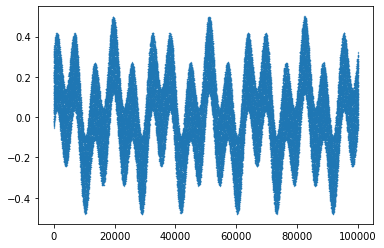

In [0]:
plt.scatter(range(vals.size(0)), vals_normed.data.tolist(), s = 0.1)
# plt.scatter(range(plot_vals.size(0)), plot_vals.data.tolist(), s = 0.1)

In [0]:
# Linear Layer Autoencoder

class AE(nn.Module):
    def __init__(self, neurons = 256, n_in = 1000, l1=2, l2=5):
        super(AE, self).__init__()
        
        l1 = 1.2
        l2 = 1.5
        
        self.sigm = torch.nn.ReLU() 
        
        
        self.linear_in = nn.Linear(in_features = n_in, out_features = neurons)
        self.linear_in2 = nn.Linear(in_features = neurons, out_features = int(neurons/l1))
        self.linear_in3 = nn.Linear(in_features= int(neurons/l1), out_features = int(neurons/l1))
        self.linear_in4 = nn.Linear(in_features= int(neurons/l1), out_features = int(neurons/l1))
        self.linear_in5 = nn.Linear(in_features= int(neurons/l1), out_features = int(neurons/l2))
        
        self.linear_out1 = nn.Linear(in_features = int(neurons/l2), out_features = int(neurons/l1))
        self.linear_out2 = nn.Linear(in_features = int(neurons/l1), out_features = int(neurons/l1))
        self.linear_out3 = nn.Linear(in_features= int(neurons/l1), out_features = int(neurons/l1))
        self.linear_out4 = nn.Linear(in_features= int(neurons/l1), out_features = neurons)
        self.linear_out5 = nn.Linear(in_features = neurons, out_features = n_in)
        
    def forward(self, data):
#         nhpp = torch.FloatTensor(nhpp).cuda()
#         ohpp = torch.FloatTensor(ohpp).cuda()
#         output = data.cuda()
        encoded = self.encode (data)
        decoded = self.decode (encoded)

        
        return decoded.squeeze(0).squeeze(0)
      
    def encode(self, data):
        output = data.cuda()
        output = self.sigm(self.linear_in(output))
        output = self.sigm(self.linear_in2(output))
        output = self.sigm(self.linear_in3(output))
        output = self.sigm(self.linear_in4(output))
        output = self.sigm(self.linear_in5(output))
        
        return output
    
    def decode(self, input):
        output = input
        output = self.sigm(self.linear_out1(output))
        output = self.sigm(self.linear_out2(output))
        output = self.sigm(self.linear_out3(output))
        output = self.sigm(self.linear_out4(output))
        output = self.linear_out5(output)
        
        return output
        

In [0]:
n_in = vals_normed[0:test_break].size(0)
sequence = torch.FloatTensor(vals_normed[0:test_break]).reshape((1, 1, n_in))
print (sequence.size())
batch_size_ae = 48
lr = 1e-3
max_epoch = 500
n_skip = 50
graph_cst = 10
valid_loss_save = []
net = AE(neurons = n_skip, n_in = batch_size_ae).cuda()
# net.load_state_dict(torch.load('model.pth'))


loss_fct = RMSELoss()
loss_save = []
batches = int(sequence.size(2)/batch_size_ae)
lstm_layers = 3
# sequence = seq_maker(noise = True, var = var)
epoch = 0
test_seshs = int(np.floor(len(values_test)/48))
valid_loss = 10000

for epoch in range(epoch, max_epoch):
        optimizer = optim.Adam(net.parameters(),lr=lr)

        optimizer.zero_grad()
        loss = 0
        for i in range (50):
          
            j = random.randint(0, n_in - batch_size_ae - 1)
            batch = torch.FloatTensor(sequence[:,:,j : (j + batch_size_ae)]).cuda()
            
            
            if(sequence[:,:,j:j+batch_size_ae].size(2) < 48):
                print (j, sequence[:,:,j:j+batch_size_ae].size(), sequence.size())
            logits = net(data = batch)

            sz = logits.size(0)


            temp_loss = loss_fct(logits, batch)
            loss = loss + temp_loss
        
        loss = loss  / (50)
  
  
  
        if (epoch % graph_cst == 0):
            print ('got here')
            v_loss = 0
            with torch.no_grad():
              for test_step in range (test_seshs):

                batch = torch.FloatTensor(values_test[test_step:test_step + 48]).cuda()
                x = batch

                logits = net(x)
                l = logits 
                sz = logits.size(0)
                temp_loss = loss_fct(logits, batch)
                v_loss += temp_loss
              v_loss = v_loss / test_seshs
#               print (v_loss)
              if (v_loss < valid_loss):
                best_valid_epoch = epoch
                valid_loss = v_loss
                best_net = AE(neurons = n_skip, n_in = batch_size_ae).cuda()
                best_net.load_state_dict(copy.deepcopy(net.state_dict()))
                print (epoch, valid_loss)
                valid_loss_save.append(float(valid_loss))
              
        loss.backward()

        optimizer.step()
    

torch.Size([1, 1, 79999])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 48])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


got here
0 tensor(0.2520, device='cuda:0')
got here
10 tensor(0.2450, device='cuda:0')
got here
20 tensor(0.2413, device='cuda:0')
got here
30 tensor(0.2412, device='cuda:0')
got here
40 tensor(0.2371, device='cuda:0')
got here
50 tensor(0.2311, device='cuda:0')
got here
60 tensor(0.2289, device='cuda:0')
got here
70 tensor(0.2288, device='cuda:0')
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
480 tensor(0.2287, device='cuda:0')
got here


In [0]:
net = AE(neurons = n_skip, n_in = batch_size_ae).cuda()
net.load_state_dict(copy.deepcopy(best_net.state_dict()))

<All keys matched successfully>

In [0]:
# Calculating the new dataset. Run every point through the AE as many times as possible, sum the results and then divide
# the value of each point by the number of times it appeared through the AE
n_in = len(vals)
new_vals = torch.zeros(len(vals))
sequence = torch.FloatTensor(vals_normed).reshape((1, 1, len(vals)))
with torch.no_grad():
  for i in range (n_in - batch_size_ae + 1):
    batch = torch.FloatTensor(sequence[:,:,i : (i + batch_size_ae)]).cuda()
    logits = net(data = batch).squeeze(0).squeeze(0)
    for j in range (batch_size_ae):
      new_vals[i + j] = new_vals[i + j] + logits[j]
  for i in range (n_in):
    if (i<48):
      new_vals[i] = new_vals[i] / (i+1)
    elif(i>(n_in-48)):
      new_vals[i] = new_vals[i] / (n_in-i)
    else:
      new_vals[i] = new_vals[i] / 48
  print (loss_fct(new_vals, vals_normed))

tensor(0.1112)


In [0]:
ae_path = 'ae_model'
ae_weights_path = 'ae_weights'
torch.save(best_net, ae_path)
torch.save(best_net.state_dict(), ae_weights_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# The AE didn't give good results (mostly it was just a line)
# So I decided to rescale the results of the AE 

vals = (vals-min(vals))/max(vals-min(vals)) 
new_vals = (new_vals-min(new_vals))/max(new_vals-min(new_vals)) 

In [0]:
new_vals = new_vals - 0.5
vals = vals - 0.5

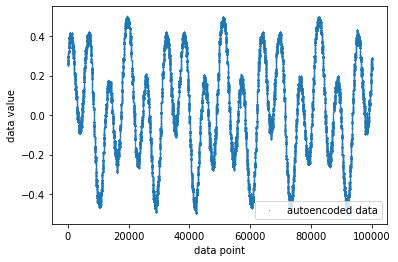

In [0]:
# And this is what we get
plt.scatter(range(new_vals.size(0)),new_vals.data.tolist(), s = 0.1, label='autoencoded data')
# plt.scatter(range(new_vals.size(0)),vals.data.tolist(), s = 0.1, label='real data')
plt.xlabel('data point')
plt.ylabel('data value')
plt.legend()

In [0]:

new_values = new_vals[0 : val_break]
new_values_valid = new_vals[val_break : test_break]
new_values_test = new_vals[test_break:(len(vals))]

In [0]:

# Function used to create the near history past points (nhpp for short)
def past_points_collector(values, nhpp_nbr):
  # Precomputing nhpp and additional features
  # nhpp = near history past points (i.e. past points introduced as features)
  # additional_features = days of the month (not one-hotted) + one-hot days of the week + one-hot months of the year

  
  if (additional_features == 50):
  
  
    nhpp = []

    days_oh = list(np.zeros(31))
    days_oh[days[nhpp_nbr]] = 1
    nhpp.extend(days_oh)

    weekdays_oh = [0, 0, 0, 0, 0, 0, 0]
    weekdays_oh[weekdays[nhpp_nbr]] = 1
    nhpp.extend(weekdays_oh)

    months_oh = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    months_oh[months[nhpp_nbr]] = 1
    nhpp.extend(months_oh)

    nhpp.extend(values[0 : nhpp_nbr])


    nhpp = torch.FloatTensor(nhpp).unsqueeze(1).unsqueeze(0).cuda()

    for i in range (nhpp_nbr  + 1, len(values)):

      nhpp_temp = []
#       print (days[i])
      days_oh = list(np.zeros(31))
      days_oh[days[i]-1] = 1
      nhpp_temp.extend(days_oh)

      weekdays_oh = [0, 0, 0, 0, 0, 0, 0]
      weekdays_oh[weekdays[i]] = 1
      nhpp_temp.extend(weekdays_oh)

      months_oh = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      months_oh[months[nhpp_nbr]] = 1
      nhpp_temp.extend(months_oh)
      nhpp_temp.extend(values[i - nhpp_nbr : i])

      nhpp_temp = torch.FloatTensor(nhpp_temp).unsqueeze(1).unsqueeze(0).cuda()
      nhpp = torch.cat((nhpp, nhpp_temp), dim = 2)
  elif(additional_features == 0):
    
    nhpp = []
    
    if (nhpp_nbr > 0):
      nhpp.extend(values[0 : nhpp_nbr])
      nhpp = torch.FloatTensor(nhpp).unsqueeze(1).unsqueeze(0).cuda()
      for i in range (nhpp_nbr + 1, len(values)):

        nhpp_temp = []

        nhpp_temp.extend(values[i - nhpp_nbr : i])
        nhpp_temp = torch.FloatTensor(nhpp_temp).unsqueeze(1).unsqueeze(0).cuda()
        
        nhpp = torch.cat((nhpp, nhpp_temp), dim = 2)
    
    else:
      nhpp = torch.FloatTensor(nhpp).unsqueeze(1).unsqueeze(0).cuda()
      for i in range (0, len(values)):
        nhpp_temp = torch.FloatTensor([]).unsqueeze(1).unsqueeze(0).cuda()
        
        nhpp = torch.cat((nhpp,nhpp_temp), dim = 2)
      
    
    
  elif(additional_features == 3):
    nhpp = [days[nhpp_nbr], weekdays[nhpp_nbr], months[nhpp_nbr]]
    if (nhpp_nbr > 0):
      nhpp.extend(values[0 : nhpp_nbr])
      nhpp = torch.FloatTensor(nhpp).unsqueeze(1).unsqueeze(0).cuda()

      for i in range (nhpp_nbr + 1, len(values)):
        nhpp_temp = [days[i], weekdays[i], months[i]]
        nhpp_temp.extend(values[i - nhpp_nbr : i])
        nhpp_temp = torch.FloatTensor(nhpp_temp).unsqueeze(1).unsqueeze(0).cuda()

        nhpp = torch.cat((nhpp, nhpp_temp), dim = 2)

    else:
      nhpp = torch.FloatTensor(nhpp).unsqueeze(1).unsqueeze(0).cuda()
      for i in range (0, len(values)):
        nhpp_temp = torch.FloatTensor([days[nhpp_nbr], 
                                       weekdays[nhpp_nbr], 
                                       months[nhpp_nbr]]).unsqueeze(1).unsqueeze(0).cuda()

        nhpp = torch.cat((nhpp, nhpp_temp), dim = 2)
    
    
    
  return nhpp

In [0]:
# Generating each point given its past (used for prediction of 30 points into the future)

additional_features = 50
def test_generation(first_points = 0,last_points = 0, 
                    prediction_window = 30, nt = None, 
                    nhpp = None, plot = False):
  # Finding the difference between the two 
  i = 0
  loss_fct = RMSELoss()
  nhpp_nbr = nhpp.size(1) - additional_features
  batch = torch.FloatTensor(values_test[i : (i+batch_size)]).cuda()
  nhpp_sample = nhpp[:,:, i : (i+batch_size)].cuda()

  x = (batch[:-1], nhpp_sample[0,:,:-1])
  
  logits = nt(x)
  
  
  start_point = batch.size(0) - logits.size(0)
  
  
  n = len(values_test)-start_point
  results = []
  for i in range (0,n-prediction_window+1, prediction_window):
    index = value2index[ values_test[i + prediction_window] ]
    batch_temp = values_test[i : (i + start_point + 1)]
    nhpp_temp = nhpp[:,:,i: (i + start_point + 1)].squeeze(0).transpose(0,1)
    for j in range (prediction_window):
      batch = torch.FloatTensor(batch_temp).cuda()
      nhpp_sample = nhpp_temp.clone()
      nhpp_sample = nhpp_sample.transpose(0,1).cuda()
      x = (batch[:-1], nhpp_sample[:,:-1])
      y = nt.forward(x)
      batch_temp = batch_temp[1:]
      batch_temp.append(torch.FloatTensor([float(y.data)]))
  
      features = []
      
      if (additional_features == 50):
  
        nhpp_temp = nhpp_temp[:][1:]
      
        days_oh = list(np.zeros(31))
        days_oh[days[index]] = 1
        features.extend(days_oh)

        weekdays_oh = [0, 0, 0, 0, 0, 0, 0]
        weekdays_oh[weekdays[index]] = 1
        features.extend(weekdays_oh)

        months_oh = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        months_oh[months[index]] = 1
        features.extend(months_oh)
        
        if nhpp_nbr > 0:
          features.extend(batch_temp[-nhpp_nbr:])

        features = torch.Tensor(features).cuda().unsqueeze(0)
        nhpp_temp = torch.cat((nhpp_temp, features), dim = 0)
        
        
      else:
        nhpp_temp = nhpp_temp[:][1:]
        
        if nhpp_nbr > 0:
          features.extend(batch_temp[-nhpp_nbr:])

        features = torch.Tensor(features).cuda().unsqueeze(0)
        nhpp_temp = torch.cat((nhpp_temp, features), dim = 0)
      
        
        
      results.append(float(y.data))
  targets2 = values_test[start_point:(start_point+(math.floor(n/prediction_window))*prediction_window)]
  
  loss2 = loss_fct (torch.FloatTensor(results), torch.FloatTensor(targets2))
  
  
  test_data_outside = (n-prediction_window+1) % prediction_window
  
  
  bench_loss = loss_fct(torch.Tensor(tanke_bench[start_point:(start_point+(math.floor(n/prediction_window))*prediction_window)]), 
                        torch.Tensor(test_targets_bench[start_point:(start_point+(math.floor(n/prediction_window))*prediction_window)]))
  
  diff = loss2 - bench_loss
  
    

    
    
  if (plot == True):
    print ('generation loss for nhpp = ', nhpp_nbr, ' is:', float(loss2.data.tolist()), 'while benchmark loss for window:', bench_loss)
    print ('generation - benchmark', loss2 - bench_loss)
    

    window_loss = loss_fct(torch.FloatTensor(results[first_points:last_points]), torch.FloatTensor(targets2[first_points:last_points]))
    plt.plot(results, ms = 0.1, color = 'green', label = 'predictions')
    plt.plot(tanke_bench[start_point:(start_point+(math.floor(n/prediction_window))*prediction_window)], ms = 0.1, label = 'benchmark')
    plt.plot(targets2, ms = 0.1, label = 'targets')
    plt.legend()
    plt.show()
  targets2 = torch.FloatTensor(targets2)
  results = torch.FloatTensor(results)
  return diff, float(loss2.data)

In [0]:
# The actual network
class WaveNet(nn.Module):
    def __init__(self, mu=1,n_residue=48, n_skip= 256, dilation_depth=10, 
                 n_repeat=5, nhpp = 50, nhpp_nbr = 0, additional_features = 0):
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.nhpp_nbr = nhpp_nbr
        self.dilation_depth = dilation_depth
        dilations = self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
#         self.one_hot = One_Hot(mu)
        self.from_input = nn.Conv1d(in_channels=mu, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_skip, kernel_size=1)
                         for d in dilations]) 
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=1)
                         for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        
        if (additional_features > 0):      
          self.linear1 = nn.Linear(in_features= n_skip + nhpp_nbr + additional_features, out_features=mu) # + 3, i.e. month, day, weekday
        else:
          self.linear1 = nn.Linear(in_features= n_skip + nhpp_nbr, out_features=mu)
          
          
        if (nhpp_nbr + additional_features > 0): 
          self.linear_nhpp = nn.Linear(in_features = nhpp_nbr + additional_features, 
                                         out_features = nhpp_nbr + additional_features)
          
        self.dropout = nn.Dropout (p=0.5)
        
    def forward(self, input):
        # Separating histories
        history, nhpp = input
        
        
        
#         history = sigm(history) # Filtering the entire history, to remove and check that way
        wn_history = self.preprocess(history) # Preparing the history for the Wavenet sequence
        ######### Wavenet Sequence ##########
        
        skip_connections = []
        loop_cst = 0
        # Convolution sequence
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            wn_history, skip = self.residue_forward(wn_history, s, t, skip_scale, residue_scale)
            
            skip_connections.append(skip)
        # sum up skip connections
        wn_history = sum([s[:,:,-wn_history.size(2):] for s in skip_connections]) # If standard Wavenet
        ######## End of Wavenet Sequence #########
        # 
        output = self.postprocess(wn_history, nhpp)
        
        
        return output
    
    def preprocess(self, input):
        output = input.unsqueeze(0).unsqueeze(0).cuda()
        output = self.from_input(output)
        return output
    
    
    def postprocess(self, wn_history, nhpp):
        
        
            
        # Discard first nhpp (+1) points as we don't need them - they don't have nhpp history points
        wn_history = wn_history[:,:,-wn_history.size(2)+self.nhpp_nbr:]
        
        start_point = nhpp.size(1) - wn_history.size(2)
        
        nhpp = nhpp[:,start_point:].unsqueeze(0)
  
  
        # One layer to process the nhp
        if (add_nhpp_FF == True):
          if (nhpp.size(1) + additional_features > 0):
            nhpp = torch.tanh(self.linear_nhpp(nhpp.transpose(1,2)).transpose(1,2))
        
        output = torch.cat((wn_history, nhpp), dim = 1)
        
        
        output = output.transpose(1,2)

#         Dropout
        if (add_dropout == True):
          if (training_so_dropout == True):
            output = self.dropout(output)
      
        output = self.linear1(output).squeeze(0).squeeze(1) # Last layer: linear - for regression
        
        
        return output
    
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = torch.sigmoid(output_sigmoid) * torch.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip
    
    def generate_slow(self, batch, nhpp, wn_length, n=100):
        print (nhpp.size(), batch.size())
        for _ in range(n):
            x = (batch[-wn_length - 1:], nhpp[:,:,-wn_length - 1:])
            print (x[0].size(), x[1].size())
            y = self.forward(x)
            _, i = y.max(dim=1)
            batch.append(i.data.tolist()[-1])
        return batch
    
    def generate(self, input=None, n=100, temperature=None, estimate_time=False):
        ## prepare output_buffer
        output = self.preprocess(input)
        output_buffer = []
        for s, t, skip_scale, residue_scale, d in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, self.dilations):
            output, _ = self.residue_forward(output, s, t, skip_scale, residue_scale)
            sz = 1 if d==2**(self.dilation_depth-1) else d*2
            output_buffer.append(output[:,:,-sz-1:-1])
        ## generate new 
        res = input.data.tolist()
        for i in range(n):
            output = Variable(torch.LongTensor(res[-2:]))
            output = self.preprocess(output)
            output_buffer_next = []
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale, b in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, output_buffer):
                output, residue = self.residue_forward(output, s, t, skip_scale, residue_scale)
                output = torch.cat([b, output], dim=2)
                skip_connections.append(residue)
                if i%20==0:
                    output = output.clone()
                output_buffer_next.append(output[:,:,-b.size(2):])
            output_buffer = output_buffer_next
            output = output[:,:,-1:]
            # sum up skip connections
            output = sum(skip_connections)
            output = self.postprocess(output)
            if temperature is None:
                _, output = output.max(dim=1)
            else:
                output = output.div(temperature).exp().multinomial(1).squeeze()
            res.append(output.data[-1])
        return res

In [0]:
# Function which runs the algorithm


# classes = 128
# values = periodicise(classes, vals)
# vals = ground truth, all dataset
def run_algorithm_gpu(nhpp, n_residue, n_skip, dilation_depth, n_repeat,
                      max_epoch, batch_size, learn_rate, graph_cst, batches, additional_features = 0,
                      dbd_prediction = False, add_nhpp_FF = True, add_dropout = True):
    print ('nhpp', nhpp[nhpp_nbr].size(1))
    print ('additional features', additional_features)
    print ('n_residue', n_residue)
    print ('n_skip', n_skip)
    print ('dilation_depth', dilation_depth)
    print ('n_repeat', n_repeat)
    print ('max_epoch', max_epoch)
    print ('batch_size', batch_size)
    print ('learning rate', learn_rate)
    print ('add_nhpp_FF', add_nhpp_FF)
    print ('add_dropout', add_dropout)
    best_valid_epoch = 0
    net = WaveNet(mu=1,n_residue=n_residue,n_skip=n_skip,dilation_depth=dilation_depth,
                  n_repeat=n_repeat, nhpp = nhpp, nhpp_nbr = nhpp_nbr,
                 additional_features = additional_features).cuda()
    optimizer = optim.Adam(net.parameters(),lr=learn_rate)
#     optimizer = optim.Adam(net.parameters(),lr=learn_rate)
#     opti mizer = optim.SGD(net.parameters(), lr=learn_rate, momentum=0.9)
    max_data = len(values)-batch_size
    
    
    loss_fct = RMSELoss()
    temp_loss = torch.Tensor(0)

    loss_save = [] 
    valid_loss_save = []
    valid_loss = 1000000
    last_loss = 1000000
    
    sequence_lowering_loss = 0
    
    for epoch in range(max_epoch):
        optimizer.zero_grad()
        loss = 0
        training_so_dropout = True
        for j in range(int(batches)):
            i = random.randint(0, len(values) - batch_size)
            batch = torch.FloatTensor(values[i : i + batch_size]).cuda()

            nhpp_sample = nhpp[nhpp_nbr][:,:, i : i + batch_size].cuda()
#             print (nhpp_sample.size())
            x = (batch[:-1], nhpp_sample[0,:,:-1])
            logits = net(x)
            sz = logits.size(0)
            temp_loss = loss_fct(logits, batch[-sz:])
            
            loss = loss + temp_loss
         
        loss = loss/batches
        loss.backward()
        optimizer.step()
        loss_save.append(float(loss))
        if (epoch % graph_cst == 0):
          training_so_dropout = False
      
          if (dbd_prediction == False):
#               print('-------test set, epoch {}--------'.format(epoch+1))
              batch = torch.FloatTensor(values_valid).cuda()
              nhpp_sample = nhpp_valid[nhpp_nbr]

              x = (batch[:-1], nhpp_sample[0,:,:-1])

              logits = net(x)
              l = logits 
              sz = logits.size(0)
              v_loss = loss_fct(logits, batch[-sz:])
#             t_loss = test_generation(nt = net, nhpp = nhpp[nhpp_nbr], plot=False, prediction_window = 5) # For maenners dataset
          else:    
            diff, t_loss = test_generation(nt = net, nhpp = nhpp_test[nhpp_nbr], plot=False, prediction_window = 30)
            
          if (v_loss < valid_loss):
            best_valid_epoch = epoch
            valid_loss = v_loss
            best_net = WaveNet(mu=1,n_residue=n_residue,n_skip=n_skip,dilation_depth=dilation_depth,
                                n_repeat=n_repeat, nhpp = nhpp, nhpp_nbr = nhpp_nbr,
                                additional_features = additional_features).cuda()
            best_net.load_state_dict(copy.deepcopy(net.state_dict()))
            
            valid_loss_save.append(float(valid_loss))
            
            
#           if(t_loss > last_loss):
#             sequence_lowering_loss += 1
#           else:
#             sequence_lowering_loss = 0
# #           print (sequence_lowering_loss, last_loss)
#           last_loss = t_loss
#           if(sequence_lowering_loss > 20):
#               print ('epoch finished', epoch)
#               break
            
            
    
            
#             print (t_loss, test_loss)
     
    return best_net, loss_save, valid_loss_save, best_valid_epoch

In [0]:
# Applying algorithm to the data, takes a long ass time

additional_features = 0
prediction_train_size = 100

import time


n_skips = [2000]
# n_skips = [300, 700]


# learn_rates = [1e-3, 3e-3, 5e-3]
learn_rates = [1e-3]

nhpp_nbrs = [0] # tanke & tanke_ts & baerchen
# nhpp_nbrs = [0, 28] # maenners

# nhpp_nbrs = [0, 42]


# dilation_depths = [6, 7] # tanke & tanke_ts & baerchen
dilation_depths = [12] # maenners
# dilation_depths = [6]

training_so_dropout = True
add_nhpp_FF = False
add_dropout = False





# Constants

number_of_experiments = 30 #constant saying how many experiments should be run for one setting of hyperparameters
# it's used to calculate the mean standard deviation of the test loss in the case we want to make a comparison with 
# other models



max_epoch = 1000
batches = 5
graph_cst = math.floor(max_epoch/50)
print ('graph cst', graph_cst)
n_residue = 25
n_repeat = 2







calc_length = len(nhpp_nbrs)*len(dilation_depths)*len(n_skips)*len(learn_rates) * number_of_experiments
calc_count = 0
dbd_prediction = False




net = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))
nhpp = defaultdict(int)
nhpp_test = defaultdict(int)
nhpp_valid = defaultdict(int)
losses = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(
                                lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))))))


print (len(values))


for nhpp_nbr in nhpp_nbrs:
  for learn_rate in learn_rates:
    nhpp[nhpp_nbr] = past_points_collector(values = new_values, nhpp_nbr = nhpp_nbr)
    nhpp_test[nhpp_nbr] = past_points_collector(new_values_test, nhpp_nbr)
    nhpp_valid[nhpp_nbr] = past_points_collector(new_values_valid, nhpp_nbr)

    for n in range(len(n_skips)):
      
      n_skip = n_skips[n] - nhpp_nbr - additional_features

        #   for n_skip in n_skips:

      for dilation_depth in dilation_depths:
            batch_size = 2**(dilation_depth+1) + nhpp_nbr + prediction_train_size
            total_train_loss = torch.zeros(max_epoch)
            total_valid_loss = []
            best_valid_train_loss = []
            total_test_loss = []
    #     for nhpp_nbr in nhpps:


            for repeat in range (number_of_experiments):

              
              start = time.time()
              calc_count += 1


              net[nhpp_nbr][n_skip][dilation_depth][learn_rate], loss_save, valid_loss, best_valid_epoch = run_algorithm_gpu(nhpp = nhpp, 
                                                   n_residue = n_residue, 
                                                   n_skip = n_skip, 
                                                   dilation_depth = dilation_depth,  
                                                   n_repeat = n_repeat,
                                                   batch_size = batch_size, 
                                                   learn_rate = learn_rate, 
                                                   max_epoch = max_epoch,
                                                   graph_cst = graph_cst,
                                                   additional_features = additional_features,
                                                   dbd_prediction = dbd_prediction,
                                                   batches = batches,
                                                   add_nhpp_FF = add_nhpp_FF,
                                                   add_dropout = add_dropout)
          
              print ('best validation epoch', best_valid_epoch)
              
              
              # Calculating test loss
              batch = torch.FloatTensor(values_test).cuda()
              nhpp_sample = nhpp_test[nhpp_nbr]
              x = (batch[:-1], nhpp_sample[0,:,:-1])
              logits = net[nhpp_nbr][n_skip][dilation_depth][learn_rate](x)
              sz = logits.size(0)
              t_loss = loss_fct(logits, batch[-sz:])
              
              
              
          
              total_train_loss += torch.Tensor(loss_save)
              total_valid_loss.append(min(valid_loss))
              best_valid_train_loss.append(loss_save[best_valid_epoch])
              total_test_loss.append(float(t_loss))
              
              
              
              end = time.time()
              print ('---------------', 'done', (calc_count/calc_length) * 100, 
                    '% -----------------', 'time left', (end-start) * (calc_length-calc_count))
            
            
            total_train_loss = total_train_loss / number_of_experiments
            total_valid_loss = np.mean(total_valid_loss) 
            best_valid_train_loss = np.mean(best_valid_train_loss) 
#             total_test_loss = total_test_loss
            
            
            losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch] = [total_train_loss, 
                                                                                                                np.mean(total_valid_loss),
                                                                                                                np.mean(best_valid_train_loss),
                                                                                                                np.mean(total_test_loss),
                                                                                                                np.std(total_test_loss)]
            
              #         test_generation(first_points = 0, last_points = 60, prediction_window = 30)

graph cst 20
59999
nhpp 0
additional features 0
n_residue 25
n_skip 2000
dilation_depth 12
n_repeat 2
max_epoch 1000
batch_size 8292
learning rate 0.001
add_nhpp_FF False
add_dropout False
best validation epoch 800
--------------- done 3.3333333333333335 % ----------------- time left 14332.281979084015
nhpp 0
additional features 0
n_residue 25
n_skip 2000
dilation_depth 12
n_repeat 2
max_epoch 1000
batch_size 8292
learning rate 0.001
add_nhpp_FF False
add_dropout False
best validation epoch 860
--------------- done 6.666666666666667 % ----------------- time left 13860.447099685669
nhpp 0
additional features 0
n_residue 25
n_skip 2000
dilation_depth 12
n_repeat 2
max_epoch 1000
batch_size 8292
learning rate 0.001
add_nhpp_FF False
add_dropout False
best validation epoch 560
--------------- done 10.0 % ----------------- time left 13327.98534822464
nhpp 0
additional features 0
n_residue 25
n_skip 2000
dilation_depth 12
n_repeat 2
max_epoch 1000
batch_size 8292
learning rate 0.001
add_nhpp

In [0]:
total_time_end = time.time()
total_duration = total_time_start - total_time_end
class l_class:
  def __init__(self):

        self.nhpp_nbr = 0

        self.n_residue  = 0

        self.n_skip  = 0

        self.n_repeat   = 0
        
        self.prediction_train_size = 0
        
        self.dilation_depth = 0
        
        self.learn_rate = 0
        
        self.max_epoch = 0
        
        self.loss_train = []
        self.loss_train_zero = []
        
        self.loss_valid = 0
        self.loss_valid_zero = 0
        
        self.loss_test = 0
        self.loss_test_zero = 0
        
        self.best_valid_train_loss = 0
        self.best_valid_train_loss_zero = 0
        
        self.test_std = 0
        
        self.nbr_of_experiments = 0

        self.total_time_duration = 0

In [0]:
# Cell which saves the results for later analysis
# Showing the results and deciding which ones are good and which ones are not
write_file_title = ""
if (make_dataset == True):
  if (add_nhpp_FF == True):
    write_file_title = write_file_title + 'FF_'
  write_file_title = write_file_title + "AE_Wavenet_noise_"+str(noise)+"_results.txt"

else:
  write_file_title = "Autoencoder_Wavenet_"

  if (add_nhpp_FF == True):
    write_file_title = write_file_title + "FF_"
  if (add_dropout == True):
    write_file_title = write_file_title + "dropout_"
  write_file_title = write_file_title +  file + "_results.txt"
  
test_stds = []

f = open(write_file_title,"wb")
object_list = []

loss_fct = RMSELoss()
min_los = 10000
min_diff = 10000
los_list = []
for nhpp_nbr in losses.keys():
  for n_residue in losses[nhpp_nbr].keys():
    for n_skip in losses[nhpp_nbr][n_residue].keys():
      for dilation_depth in losses[nhpp_nbr][n_residue][n_skip].keys():
        for n_repeat in losses[nhpp_nbr][n_residue][n_skip][dilation_depth].keys():
          for prediction_train_size in losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat].keys():
            for learn_rate in losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size].keys():
              for max_epoch in losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate].keys():
                  if( type(losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch]) != int):
                    
                    # current results
                    los_train = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][0]
                    los_valid = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][1]
                    best_valid_train_loss = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][2]
                    test_los = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][3]
                    test_std = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][4]

                    print ('test loss and test std', test_los, test_std)
                  

                    
  
                    # Writing to file
                    object_to_write = l_class()
                    
                    object_to_write.nhpp_nbr      = nhpp_nbr

                    object_to_write.n_residue       = n_residue

                    object_to_write.n_skip      = n_skip

                    object_to_write.n_repeat   = n_repeat

                    object_to_write.prediction_train_size = n_repeat

                    object_to_write.learn_rate = learn_rate
                    
                    object_to_write.dilation_depth = dilation_depth

                    object_to_write.max_epoch = max_epoch
                    
                    object_to_write.loss_train = los_train
                    
                    object_to_write.loss_valid = los_valid
                    
                    object_to_write.loss_test = test_los

                    object_to_write.best_valid_train_loss = best_valid_train_loss
                    
                    object_to_write.test_std = test_std
                    
                    object_to_write.nbr_of_experiments = number_of_experiments

                    object_to_write.total_time_duration = total_duration
                    
                    object_list.append(object_to_write)
                    
                    
pickle.dump(object_list, f)
f.close()

0.22462311734755833 0.0003335196853955323


NameError: ignored